## Authors: Rehan Nasir, Jhomar Gharbarran, Aditya Shah, Aryan Chaudhary

# Flight Prediction Dataset Description
**Features for the dataset:**
1. airline - airline company (nominal: "Air_India", "AirAsia", "GO_FIRST", "Indigo", "SpiceJet", or "Vistara")
2. flight - flight code (nominal: "SG-8709", "I5-764", ...)
3. source_city - take off city (nominal: "Bangalore", "Chennai", "Delhi", "Hyderabad", "Kolkata", or "Mumbai")
4. departure_time - flight's departure time (nominal: "Early_Morning", "Morning", "Afternoon", "Evening", "Night" or "Late_Night")
5. stops - flight's layovers (nominal: "zero", "one", "two_or_more")
6. arrival_time - flight's arrival time (nominal: "Early_Morning", "Morning", "Afternoon", "Evening", "Night" or "Late_Night")
7. destination_city - landing city (nominal: "Bangalore", "Chennai", "Delhi", "Hyderabad", "Kolkata", or "Mumbai")
8. class - seat class (nominal: "Economy" or "Business")
9. duration - flight's duration time (numeric: from 0.83 to 49.83 hours)
10. days_left - days until trip from booking time (numeric: from 1 to 49 days)
11. price - flight's price in indian rupees (numeric: from Rs.1105 to Rs.123071)



# 1 - Look at the big picture
Predictions will be used to provide insight to the user how prices of flights are given specific variables.

Framing the problem:
- Supervised Learning
  - Training examples are labelled, such as the airline/seat class/cities
- Regression Task
  - Predicting numerical data, specifically prices for a flight (**Note: Price is in indian rupees**)
- Batch Learning
  - We are using a dataset given a specific timeframe (50 days - Feb 11th, 2022 to March 31st, 2022) so there is no newer data being continuously put into the system and no need to adjust to changing data

### Loading the data

In [1]:
# Import the basic libraries required
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning) # suppress this warning

# Using the Pandas library to download and load the dataset into a DataFrame
url = "https://raw.githubusercontent.com/rehan-nasir/flight-price-predictions/main/Dataset/Clean_Dataset.csv"
flight_data = pd.read_csv(url, sep=',')

# 2 - Exploratory Data Analysis (EDA)
As mentioned previously about giving insight the user about how prices of flights are, it is important that we analyze the given variables:
- Specific airline with their economy and business seat classes
- Source and destination city
- Amount of stops
- Departure time and arrival time
- Duration of flight
- Number of days the ticket purchased in advance

These will allow us to understand and notice any trends or patterns for how those variables affect the price of flights.

### 2.1 - Data Structure
First off, we will look at the data structure to know what we are working with and to verify things such as if our columns/labels/rows are correct in our dataset.

We begin by outputting the rows, columns, labels in the dataset:

In [2]:
flight_data # display rows and columns in the dataset

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


Output the list of types we're working with and check if there are any columns that are null:

In [3]:
flight_data.info() # display summary of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


Output the first 5 rows of our dataset:

In [4]:
flight_data.head() # display 1st 5 rows of the dataset

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


A summary of the all the flight's durations, days left and price:
- 25% of the flights are almost 7 hours long, are bought 15 days in advance and are Rs.4783 on average.
- 50% of the flights are about 11 hours long, are bought 26 days in advance and are Rs.7425 on average.
- 75% of the flights are about 16 hours long, are bought 38 days in advance and are Rs.42521 on average.
- The shortest duration is less than 7 hours and the max duration is almost 50 hours.
- There is data for purchases of 1 day in advance, up to 49 days in advance.
- The lowest price ever purchased was Rs.1105 and the highest price ever purchased was Rs.123071.


In [ ]:
flight_data.describe() # displays description of the dataset

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


Output the dimensionality as a tuple of our dataset:

In [ ]:
flight_data.shape # displays the dimensions of the dataset

(300153, 11)

### 2.2 - Graphs
Here we provide the variables mentioned in 2. in a visual form to help us possibly find any trends or patterns that affect the price.

We can look at the average price for each airline. This gives us insight on which airline charges the least or most for a ticket.
- Vistara and Air India appear to only be the ones that offer business class seats
- All the airlines are very similar in price for economy class seats
- AirAsia is the cheapest
- Vistara is the most expensive

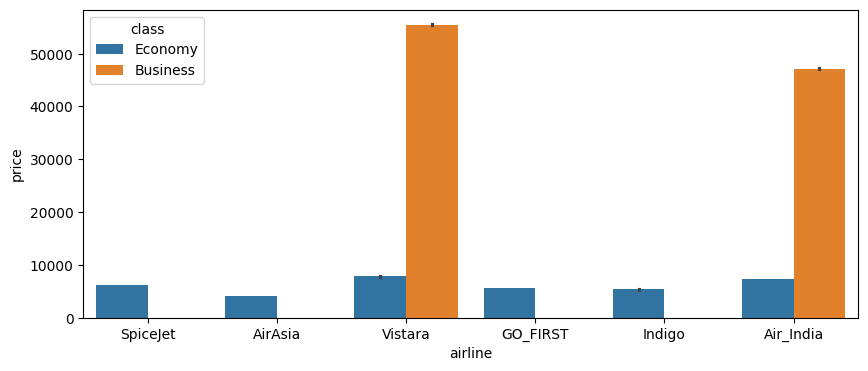

In [ ]:
# displays airline price comparison graph
plt.figure(figsize=(10, 4))
sns.barplot(x='airline', y='price', hue='class', data=flight_data)
plt.show()

We can look at the source and destination city average prices. This gives us insight on which city is the least or most expensive to travel to.
- Delhi is the cheapest to fly from and to
- Kolkata is the most expensive to fly to and from
- Prices are generally the same

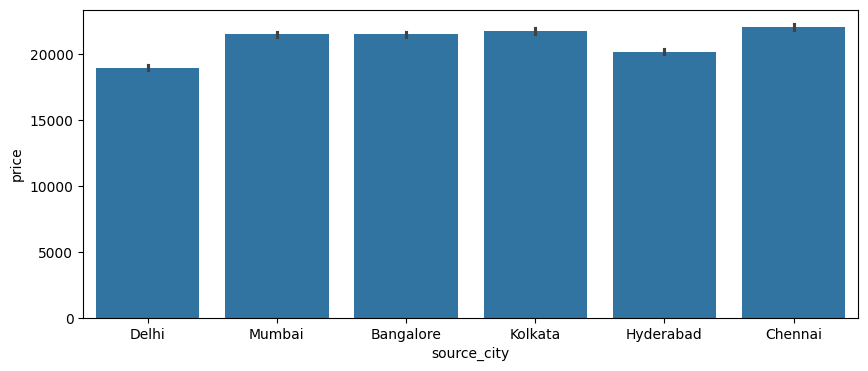

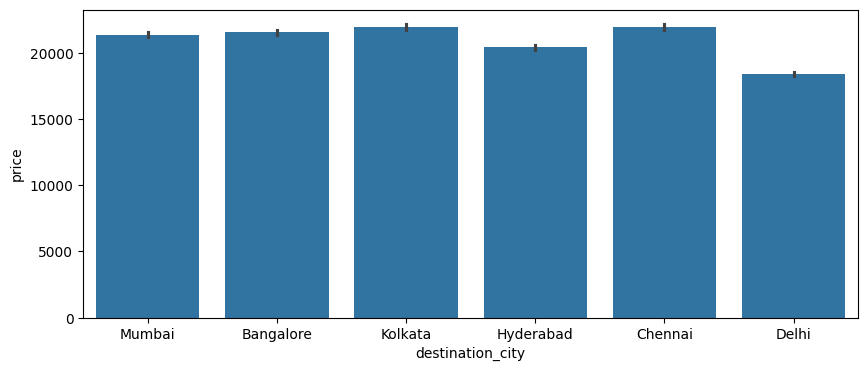

In [ ]:
# displays source and destination city averages graph
plt.figure(figsize=(10, 4))
sns.barplot(x='source_city', y='price', data=flight_data)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x='destination_city', y='price', data=flight_data)
plt.show()

We can look at the amount of stops. This gives us insight on if the amount of layovers matter.
- Non-stop flights are cheaper
- One stop flights are the most expensive

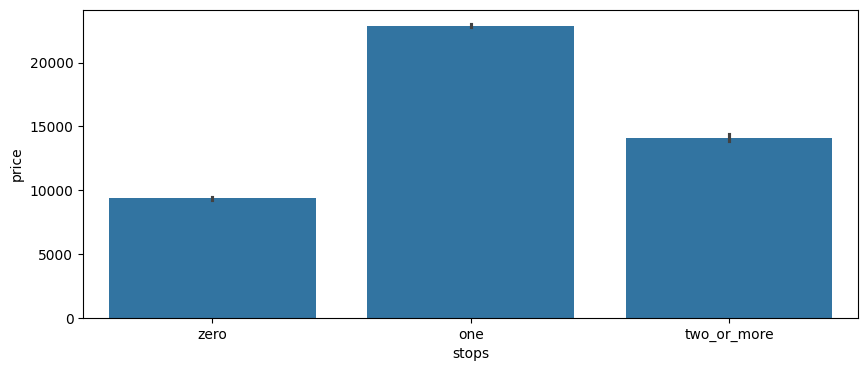

In [ ]:
# displays price vs number of stops a flight has
plt.figure(figsize=(10, 4))
sns.barplot(x='stops', y='price', data=flight_data)
plt.show()

We can look at what time we depart or arrive. This gives us insight on how the time of the day affects the price.
- It's cheaper to depart and arrive at late night
- It's more expensive to depart at night and arrive at evening

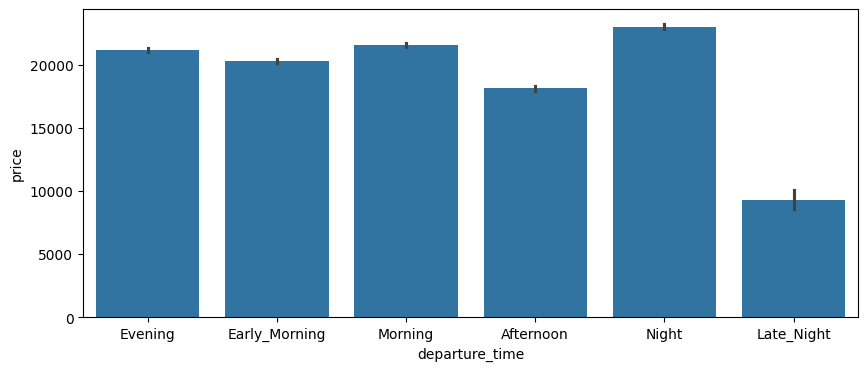

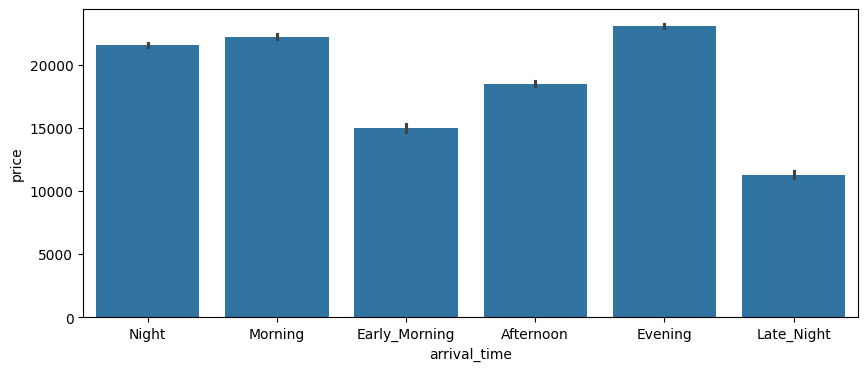

In [ ]:
# displays price vs departure time and price vs arrival time graph
plt.figure(figsize=(10, 4))
sns.barplot(x='departure_time', y='price', data=flight_data)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x='arrival_time', y='price', data=flight_data)
plt.show()

We can look at the duration of the flight. This gives us insight on if longer flights affect the price.
- Less than 10 hour flights and 30-40 hour flights are the cheapest
- Price rises and lowers between 10-30 hour flights
- There are significant outliers

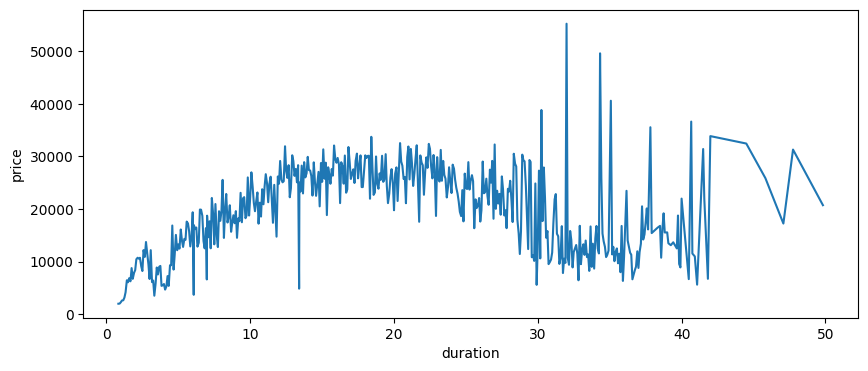

In [ ]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='duration', y='price', data=flight_data, ci=None)
plt.show()

We can look at how many days in advance the ticket is bought. This gives us insight on how early or late a ticket bought affects the price.
- The later the ticket bought the more expensive it is
- The earlier the ticket bought the less expensive it is

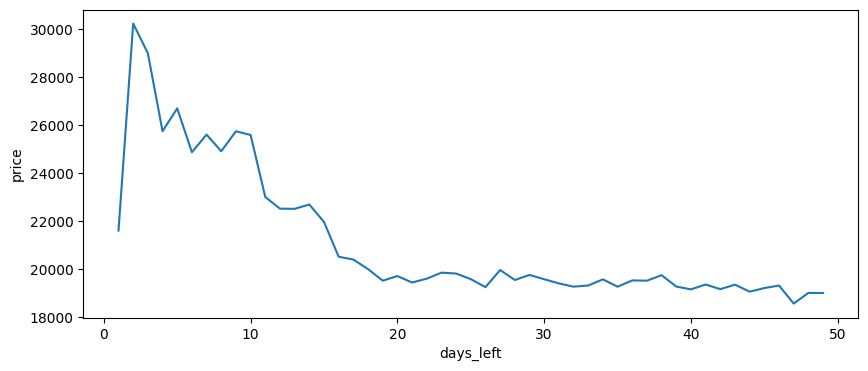

In [ ]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='days_left', y='price', data=flight_data, ci=None)
plt.show()

We also look at at a histogram of our numerical columns to visually see if our data is a gaussian distribution or not
- This is required for our preprocessing step
- Clearly, duration and price do not follow a gaussian distribution but days_left kind of does.

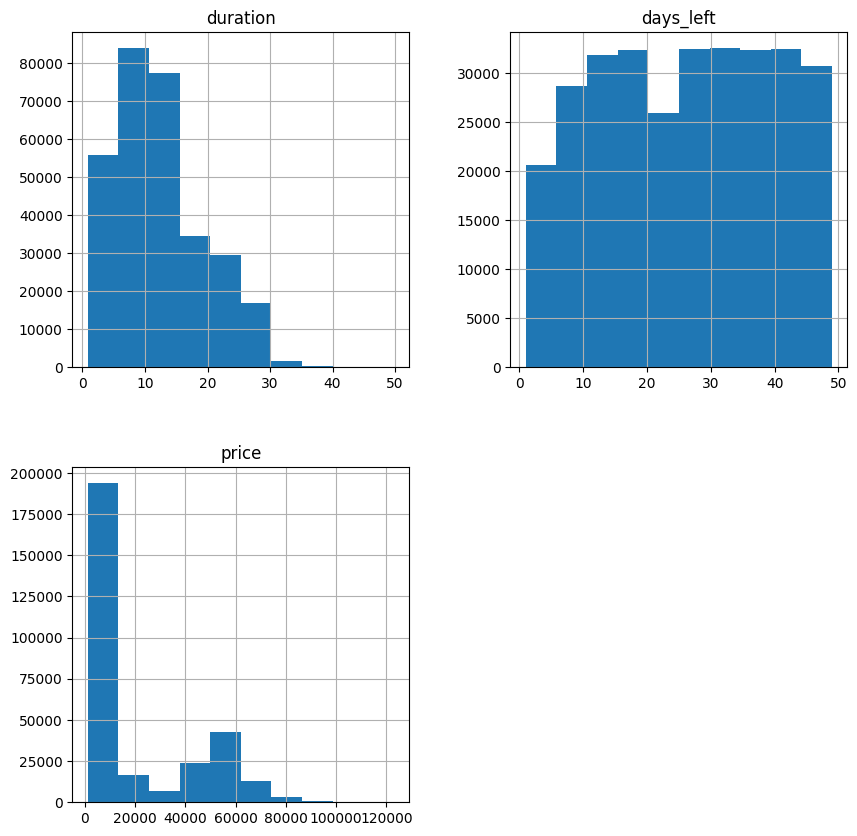

In [ ]:
flight_data.hist(figsize=(10, 10))
plt.show()

### 2.3 - Correlation
We can use the standard correlation coefficient (or Pearson's r) to know which numeric set of data have linear correlation.
- In this case, there is not really any linear correlation in our data.
- There is a slightly high linear correlation between duration and price (0.2).
    - This means the duration and price increase together.
- There is a negative correlation between price and days left.
    - This may explain that the days left increasing implies the price decreases (seen in the graph in 2.2).

In [ ]:
corr_matrix = flight_data.corr(numeric_only=True)
corr_matrix

,duration,days_left,price
duration,1.000000,-0.039157,0.204222
days_left,-0.039157,1.000000,-0.091949
price,0.204222,-0.091949,1.000000


### 2.4 - Findings
Based on these graphs as an example, if one were to prioritize buying the cheapest flight (and they can start from any city and end at any city), then they would probably buy a ticket that:
- Is by AirAsia
- Is Economy
- Fly to/from Delhi (or Hyderabad if from Delhi)
- Is Nonstop
- Is a late night flight and arrives in early morning (or late night if flew in afternoon)
- Duration is less than 5 hours or 30-40 hours
- Is bought more than 20 days in advance

Some of the variables do not have a large impact on the price as shown in the graphs (such as the airline for economy or where you fly from), but there are clear moments when they do (such as the days left or duration).
There are also clearly outliers in the data, which can affect a model we choose leading to training error so it is important to keep that in mind.

# 3 - Prepare the data
Before we train a model, we need to prepare the data for modelling by cleaning (remove duplicates). Afterwards we will create and apply a preprocessing pipeline to fill any missing numerical or categorial values, and scale the numerical columns and encode the categorical columns.

### 3.1 - Remove duplicate rows & Handle missing values
Luckily our dataset does not contain any duplicated rows as it was already removed.
The same applies for missing values. Our dataset does not contain any missing values either.

In [ ]:
# Duplicates check
flight_data.drop_duplicates(inplace=True)
print("Duplicates: ", flight_data.duplicated().sum())

# Empty values check
print("NaN/None:")
print(flight_data.isna().sum())
print("Check for '?': ", (flight_data.values == '?').sum())
print("Check for ' ?': ", (flight_data.values == ' ?').sum())
print("Check for '? ': ", (flight_data.values == '? ').sum())

Duplicates:  0
NaN/None:
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64
Check for '?':  0
Check for ' ?':  0
Check for '? ':  0


### 3.2 - Preprocessing Pipeline
We can now create our preprocessing pipeline.
- Our data does not primarily follow a gaussian distribution based off the histogram previously shown so we will use MinMaxScaler().
- We will also encode the categorical data with OrdinalEncoder so we can change the "zero", "one", "Economy", etc., into numerical values.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Create the numerical and categorical columns
num_col = flight_data.select_dtypes(include='number').columns.to_list()
cat_col = flight_data.select_dtypes(exclude='number').columns.to_list()

# Remove price from numerical column as we do not want to scale the target
num_col.remove("price")

# Create pipelines for both columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())

# Set estimators and transformers
preprocessing = ColumnTransformer([('num', num_pipeline, num_col), ('cat', cat_pipeline, cat_col)], remainder='passthrough')

# Apply the pipeline to the dataset
flight_prep = preprocessing.fit_transform(flight_data)

# Re-add column headers
flight_features = preprocessing.get_feature_names_out()
flight_prep = pd.DataFrame(data=flight_prep, columns=flight_features)

# Show pipeline
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['duration', 'days_left']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['airline', 'flight', 'source_city',
                                  'departure_time', 'stops', 'arrival_time',
                                  'destination_city', 'class'])])

# 4 - Training Models
We can now proceed to split our data and select 3 models to train on our dataset.

### 4.1 - Split the dataset into a training dataset and test dataset
- We will split the dataset by 80% for training and 20% for testing.

In [ ]:
from sklearn.model_selection import train_test_split

X = flight_prep.drop(["remainder__price"], axis=1)
y = flight_prep["remainder__price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

### 4.2 - First Model: Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

LRModel = LinearRegression()
LRModel.fit(X, y)

LinearRegression()

### 4.3 - Second Model: Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

ENModel = ElasticNet()
ENModel.fit(X, y)

ElasticNet()

### 4.4 - Third Model: Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFModel = RandomForestRegressor(max_depth=8) # need max depth or it overfits
RFModel.fit(X, y)

RandomForestRegressor(max_depth=8)

# 5 - Evaluation of Models
After training our three models we can compare the performance of them with evaluation metrics:
- R^2 score (coefficient of determination)
- Mean absolute error (MAE)
- Mean squared error (MSE)
- Root mean squared error (RMSE)

### 5.1 - Predictions and Metrics
First we setup the predictions:

In [ ]:
# Linear Regression predictions
LNYPred = LRModel.predict(X_test)

# Elastic Net predictions
ENYPred = ENModel.predict(X_test)

# Random Forest predictions
RFYPred = RFModel.predict(X_test)

Then we show the metrics for each:

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# R^2 score
print("R^2 scores")
print("Linear Regression: ", r2_score(y_test, LNYPred))
print("Elastic Net: ", r2_score(y_test, ENYPred))
print("Random Forest: ", r2_score(y_test, RFYPred))

# MAE
print("\nMean Absolute Error")
print("Linear Regression: ", mean_absolute_error(y_test, LNYPred))
print("Elastic Net: ", mean_absolute_error(y_test, ENYPred))
print("Random Forest: ", mean_absolute_error(y_test, RFYPred))

# MSE
print("\nMean Squared Error")
print("Linear Regression: ", mean_squared_error(y_test, LNYPred))
print("Elastic Net: ", mean_squared_error(y_test, ENYPred))
print("Random Forest: ", mean_squared_error(y_test, RFYPred))

# RMSE
print("\nRoot Mean Squared Error")
print("Linear Regression: ", np.sqrt(mean_squared_error(y_test, LNYPred)))
print("Elastic Net: ", np.sqrt(mean_squared_error(y_test, ENYPred)))
print("Random Forest: ", np.sqrt(mean_squared_error(y_test, RFYPred)))

R^2 scores
Linear Regression:  0.9045789774846467
Elastic Net:  0.5030942976137229
Random Forest:  0.9611095407326153

Mean Absolute Error
Linear Regression:  4619.351827705677
Elastic Net:  13174.49220514903
Random Forest:  2559.825775307142

Mean Squared Error
Linear Regression:  49187845.63248092
Elastic Net:  256146081.21541572
Random Forest:  20047342.363289066

Root Mean Squared Error
Linear Regression:  7013.404710444202
Elastic Net:  16004.564386930864
Random Forest:  4477.425863516789


From the above numbers, clearly the best model is Random Forest.
The second best is Linear Regression and the worst is Elastic Net.

Elastic Net is extremely low in its R^2 score, has high MAE, MSE and RMSE compared to the other two models.
Random Forest on the other hand has 0.96 R^2 score, the lowest MAE, MSE and RMSE.
Linear Regression is a little bit behind Random Forest (about 0.06 in R^2 score) but still lower in errors compared to Elastic Net.

### 5.2 - Graphs of the Best Performing Algorithm
The following are graphs of Random Forest as it was the best algorithm used for our dataset:

In [ ]:
# Combine the prediction to original dataset to help with graphs
predFrame = pd.DataFrame({'Actual': y_test, 'Prediction': RFYPred})
combinedDataset = flight_data.merge(predFrame, left_index=True, right_index=True)

##### Prediction Price vs Actual Value
- Our model seems to more than often overestimate the actual price and underestimate.
- It severely underestimates the price for predicting the most expensive ticket.

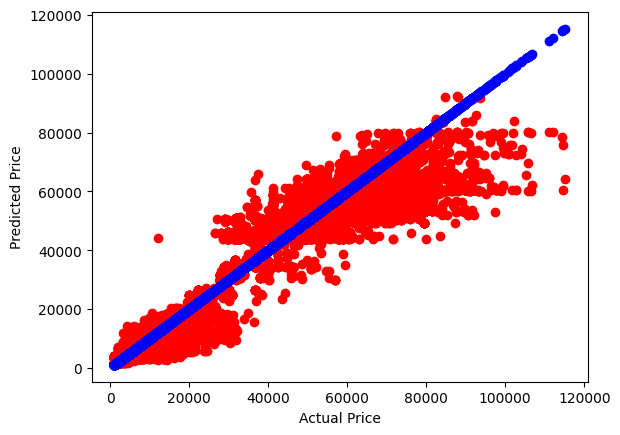

In [ ]:
# Predicted price vs actual value
plt.scatter(y_test, RFYPred, color='red')
plt.scatter(y_test, y_test, color='blue')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

##### Prediction Price vs Days Left
- Our model seems to underestimate for the prices when there is less days left and overestimate the more days there are.
- However, it is very close to the actual price.

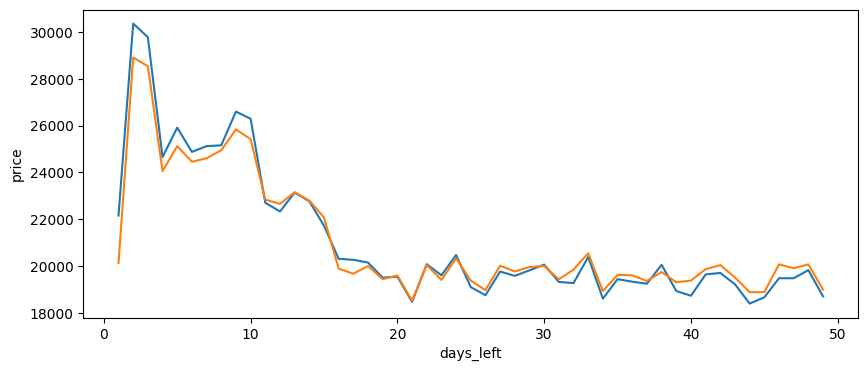

In [ ]:
# Prediction vs Days left graph
plt.figure(figsize=(10, 4))
sns.lineplot(x='days_left', y='price', data=combinedDataset, errorbar=None)
sns.lineplot(x='days_left', y='Prediction', data=combinedDataset, errorbar=None)
plt.show()

##### Prediction Price vs Duration
- We can clearly see it almost matches the spikes of the duration graph with some severe underestimations such as the 40+ hour flight.
- There is also some bias for the outliers.

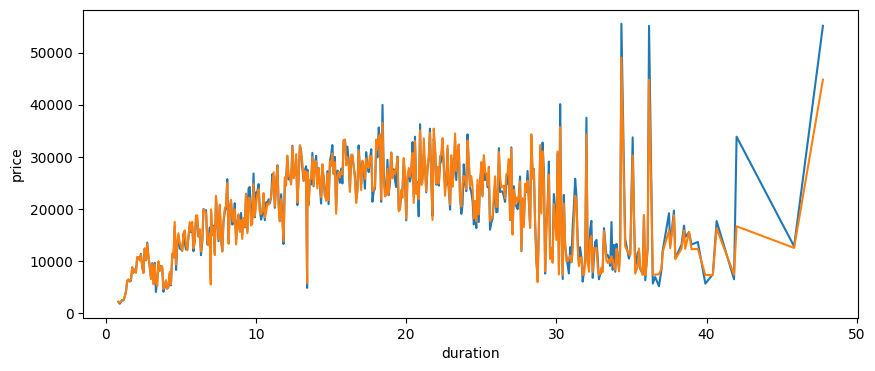

In [ ]:
# Prediction price vs duration graph
plt.figure(figsize=(10, 4))
sns.lineplot(x='duration', y='price', data=combinedDataset, errorbar=None)
sns.lineplot(x='duration', y='Prediction', data=combinedDataset, errorbar=None)
plt.show()

##### Learning Curve
**Note: Below will take a long time to run.**

In [ ]:
from sklearn.model_selection import learning_curve

# Set the trained sizes, scores for training and test with the learning curve
train_sizes, train_scores, validation_scores = learning_curve(RFModel, X_train, y_train, train_sizes=[1, 10000, 20000, 45000, 65000, 95000, 150000, 192097], cv=10, scoring='neg_mean_squared_error')

# Calculate the mean for the training score and test score
train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
validation_scores = np.sqrt(-validation_scores.mean(axis=1))

- The learning curve clearly shows that the error in training and test data almost converge together.
- This implies that there is overfitting or the variance is high.
    - This is likely due to the noisiness of the data (there are some huge outliers)

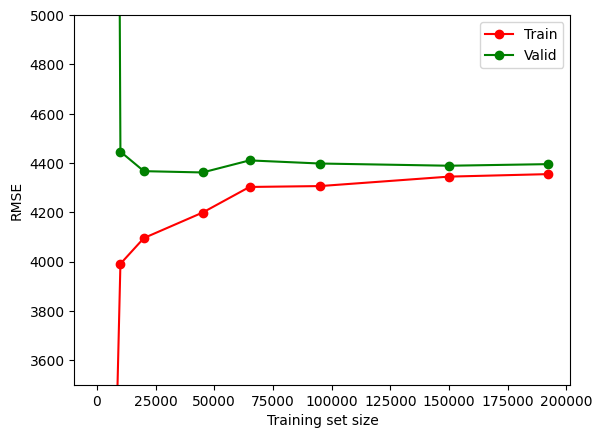

In [ ]:
# Labels
plt.xlabel("Training set size")
plt.ylabel("RMSE")

# Plots
plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Train")
plt.plot(train_sizes, validation_scores, 'o-', color="green", label="Valid")
plt.legend(loc="upper right")
plt.ylim(3500, 5000)
plt.show()